In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv")

In [3]:
df.shape

(22711, 26)

In [4]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [5]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

## 2. Add Features

In [15]:
# Add year,month and season for acution time
df["auc_date"]=pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season']=df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["untitled?"]=np.where(df["lot_title"].str.contains(words),1,0)

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
#need to change to auc_id once data available
df["auc_order"]= df.groupby("auc_title")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

In [9]:
# Add avg_estimate
df["avg_estimate"]=(df["estimate_low"]+df["estimate_high"])/2

## 3. Convert Currency

## 4. Dealing with Missing Values

In [10]:
df.isnull().any()

Unnamed: 0            False
lot_id                False
auction_id            False
lot_title              True
estimate_low           True
estimate_high          True
hammer_price_bp        True
currency               True
nth_in_auction        False
lot_number            False
condition              True
provenance             True
literature             True
external_image_url    False
auction_house_id      False
auc_title             False
number_of_lots        False
location              False
start_date            False
auc_desc               True
sale_id               False
artist_id             False
name                  False
birth_year             True
death_year             True
auc_year              False
auc_month             False
auc_season            False
untitled?             False
auc_order             False
avg_estimate           True
dtype: bool

In [12]:
df.location.value_counts()

NEW YORK     9674
LONDON       6317
PARIS        2543
AMSTERDAM    2217
MILAN        1381
HONG KONG     458
DOHA           67
DUBAI          54
Name: location, dtype: int64

In [19]:
df[df.hammer_price_bp<df.estimate_low].shape

(1449, 20)

In [20]:
df.shape

(22711, 20)

In [21]:
1449/22711

0.06380168200431509

In [51]:
'''
check=df.loc[df["untitled?"]==1]["lot_title"]
check[check.str.contains("UNTITLED")==False]
'''

'\ncheck=df.loc[df["untitled?"]==1]["lot_title"]\ncheck[check.str.contains("UNTITLED")==False]\n'

## Exploratory Analysis

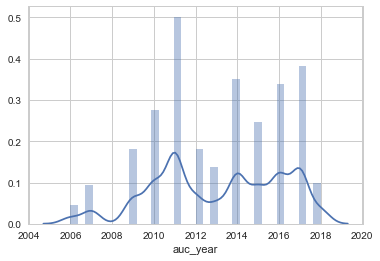

In [29]:
sns.distplot(df.auc_year)

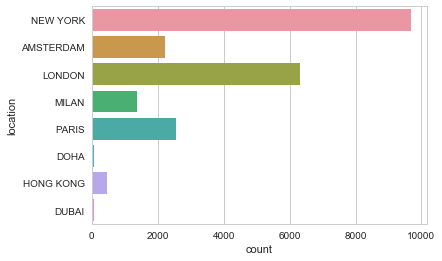

In [24]:
sns.countplot(y=df.location)


In [12]:
df.isnull().any()

lot_title              True
estimate_low           True
estimate_high          True
hammer_price_bp        True
currency               True
nth_in_auction        False
lot_number            False
condition              True
provenance             True
literature             True
external_image_url    False
auc_title             False
number_of_lots        False
location              False
start_date            False
auc_desc               True
name                  False
birth_year             True
death_year             True
dtype: bool

In [10]:
df.shape

(22711, 19)

### Is there a correlation between auction type and whether the lot is named as "untitled"?

In [95]:
title_grouped=pd.DataFrame({'count' : df.groupby(["auc_title","untitled?"]).size()}).reset_index()
title_grouped["sum"]=title_grouped["count"].groupby(title_grouped["auc_title"]).transform("sum")
untitled_title=title_grouped.loc[title_grouped["untitled?"]==1]
untitled_title["ratio"]=untitled_title["count"]/untitled_title["sum"]
untitled_title.sort_values(by=['ratio'],ascending=False,inplace=True)

/Users/serenazhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/serenazhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [99]:
untitled_title

,auc_title,untitled?,count,sum,ratio
44,Bande Dessinée - Comics,1,15,15,1.000000
43,Bande Dessinée,1,83,83,1.000000
171,Property from the Collection of Mrs. Paul Mell...,1,94,107,0.878505
15,A Tale of Two Cities: Venice and Dresden,1,56,64,0.875000
177,Property from the Estate of Queen Juliana of T...,1,1261,1480,0.852027
175,Property from the Collections of Lily & Edmond...,1,409,482,0.848548
164,Of Royal and Noble Descent,1,69,97,0.711340
68,Collection Florence Loeb ­- Sources et Affinités,1,7,10,0.700000
190,"The Collection of Allan Stone Vol. I, The Coll...",1,2,3,0.666667
76,Collections,1,223,335,0.665672


KeyError: 20

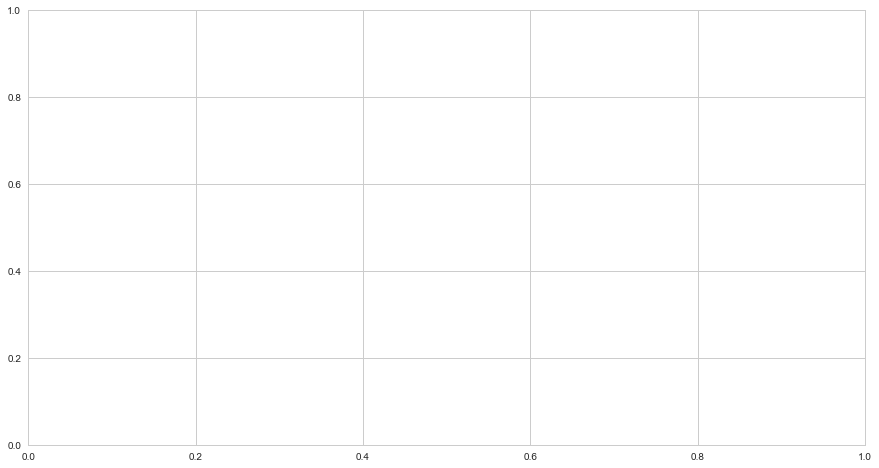

In [97]:
fig,ax=plt.subplots(figsize=(15,8))
ax=sns.barplot(x="auc_title", y="ratio", data=untitled_title.loc[:20,]);
plt.xticks(rotation=90);

In [11]:
#percentage of nas in lot_title
3901/22711

0.17176698516137553

In [113]:
df.start_date.max()

Timestamp('2018-03-28 14:00:00.098000')